## 1. Libraries and settings

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn-v0_8-darkgrid')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import vectorbtpro as vbt

from datetime import date

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore", UserWarning)

vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 800
vbt.settings['plotting']['layout']['height'] = 400

#Hyperparams
sequence_length = 80  # Example: 20 timesteps per sequence

# Update these dimensions based on your dataset
input_dim = 175  # Number of features
hidden_dim = 64
num_layers = 4
output_dim = 3  # Number of classes


In [2]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
df.fillna(method='pad');


/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_33260/3057766720.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
/var/folders/x1/twdts0414gn1_4rw0fsqsphm0000gn/T/ipykernel_33260/3057766720.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad');


In [3]:
data = vbt.Data.from_data(df)

In [4]:
features = data.run("talib", mavp=vbt.run_arg_dict(periods=14))

In [5]:
data.data['symbol'] = pd.concat([data.data['symbol'], features], axis=1)

In [6]:
data.data['symbol'].drop(['Open', 'High', 'Low'], axis=1, inplace=True)

In [7]:
# This will drop columns from the DataFrame where all values are NaN
data.data['symbol'] = data.data['symbol'].dropna(axis=1, how='all')


In [8]:
open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

data.data['symbol'] = data.data['symbol'].dropna()
predictor_list = data.data['symbol'].drop('signal', axis=1).columns.tolist()


X = data.data['symbol'][predictor_list]

y = data.data['symbol']['signal']

In [9]:
X.columns = X.columns.astype(str)

In [11]:
test_size = int(0.3*(len(X)))
X_train = X[:-test_size]
X_test = X[-test_size:]

y_train = y[:-test_size]
y_test = y[-test_size:]



In [12]:
from sklearn.preprocessing import StandardScaler

# Create a scaler instance
scaler = StandardScaler()

# Fit the scaler to your data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Create a DataFrame from the scaled data with the same index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)



In [13]:
# Fit the scaler to your data and transform
X_test_scaled = scaler.fit_transform(X_test)

# Create a DataFrame from the scaled data with the same index and columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [14]:

def create_sequences(input_data, sequence_length):
    sequences = []
    data_len = len(input_data)
    for i in range(data_len - sequence_length):
        seq = input_data[i:(i + sequence_length)]
        sequences.append(seq)
    return np.array(sequences)

# Assuming X_train_scaled_df and X_test_scaled_df are already scaled and are DataFrames
X_train_list = create_sequences(X_train_scaled_df.values, sequence_length)
X_test_list = create_sequences(X_test_scaled_df.values, sequence_length)

y_train_list = y_train[sequence_length:]
y_test_list = y_test[sequence_length:]



In [15]:
x_train = np.array(X_train_list)
x_test = np.array(X_test_list)  

y_train = np.array(y_train_list)
y_test = np.array(y_test_list)

In [16]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [17]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming y_train is your target labels tensor for the training data
# and it's already in the form of a 1D tensor of class indices (0 to C-1)

# Convert y_train to a numpy array if it's a tensor
if isinstance(y_train, torch.Tensor):
    y_train_np = y_train.cpu().numpy()
else:
    y_train_np = y_train  # Assuming y_train is already a numpy array

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)

# Convert class weights to a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [18]:
# Move class weights to the same device as your model and data
class_weights_tensor = class_weights_tensor.to('cpu')  # device could be 'cpu' or 'cuda'



In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        
        return out



# Create the model
model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Use CrossEntropyLoss for multi-class classification
# Initialize the loss function with class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=0.03)

# Assuming `optimizer` is your optimizer (e.g., Adam)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=20, gamma=0.8)


# Print the model's architecture
# print(model)


In [20]:
num_epochs = 500
# Assuming loss_fn is already defined as CrossEntropyLoss
# e.g., loss_fn = torch.nn.CrossEntropyLoss()
# For classification, it might be more informative to track accuracy or other metrics
# hist will track the loss for now
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_train_pred = model(x_train)

    # Compute loss
    loss = loss_fn(y_train_pred, y_train.long())  # Ensure y_train is of type torch.long
    if t % 10 == 0:  # Adjust logging frequency according to your preference
        print("Epoch ", t, "Loss: ", loss.item())
    hist[t] = loss.item()

    # Zero gradients before backward pass
    optimiser.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to all the learnable parameters
    loss.backward()

    # Update the parameters using the gradients and optimizer algorithm
    optimiser.step()
    
    # Step the scheduler
    scheduler.step()

    # Optional: Calculate and print accuracy or other metrics every few epochs
    # This is more meaningful for classification tasks
    if t % 10 == 0:  # Adjust as needed
        with torch.no_grad():  # No need to track gradients for validation
            y_pred_tags = torch.argmax(torch.softmax(y_train_pred, dim=1), dim=1)
            correct_preds = (y_pred_tags == y_train).float().sum()
            accuracy = correct_preds / y_train.shape[0]
            print(f'Epoch {t} Accuracy: {accuracy.item() * 100:.2f}%')


Epoch  0 Loss:  1.0999715328216553
Epoch 0 Accuracy: 67.87%
Epoch  10 Loss:  1.0541961193084717
Epoch 10 Accuracy: 47.49%
Epoch  20 Loss:  0.7603974938392639
Epoch 20 Accuracy: 18.96%
Epoch  30 Loss:  0.6257033944129944
Epoch 30 Accuracy: 34.34%
Epoch  40 Loss:  0.5140852928161621
Epoch 40 Accuracy: 56.51%
Epoch  50 Loss:  0.44200077652931213
Epoch 50 Accuracy: 57.86%
Epoch  60 Loss:  0.3120121359825134
Epoch 60 Accuracy: 72.22%
Epoch  70 Loss:  0.347171813249588
Epoch 70 Accuracy: 67.05%
Epoch  80 Loss:  0.2981968820095062
Epoch 80 Accuracy: 72.75%
Epoch  90 Loss:  0.19402597844600677
Epoch 90 Accuracy: 84.21%
Epoch  100 Loss:  0.13066141307353973
Epoch 100 Accuracy: 89.66%
Epoch  110 Loss:  0.10874933004379272
Epoch 110 Accuracy: 91.64%
Epoch  120 Loss:  0.0746937096118927
Epoch 120 Accuracy: 94.77%
Epoch  130 Loss:  0.056210752576589584
Epoch 130 Accuracy: 96.41%
Epoch  140 Loss:  0.04189596325159073
Epoch 140 Accuracy: 97.54%
Epoch  150 Loss:  0.03262890875339508
Epoch 150 Accuracy

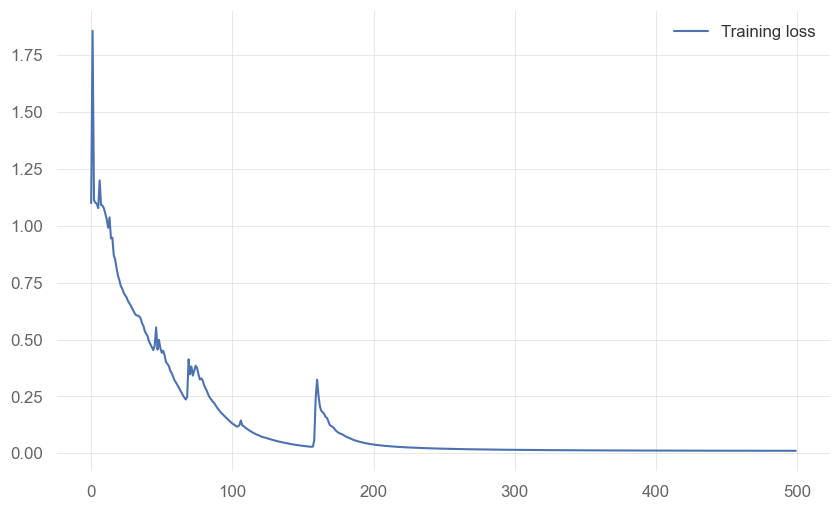

In [21]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [22]:
with torch.no_grad():
    
    y_test_pred = model(x_test)
    # Convert logits to probabilities
    probabilities = torch.softmax(y_test_pred, dim=1)

    # Get the predicted class labels
    _, predicted_labels = torch.max(probabilities, 1)
predicted_labels_numpy = predicted_labels.numpy()
len(predicted_labels_numpy)


5143

In [23]:
df_split = data.data['symbol'][-len(predicted_labels_numpy):].copy()
# len(df_split)
# df_split.shape
# predicted_labels_numpy.shape
df_split.loc[:, "signal"] = predicted_labels_numpy
signal = df_split['signal']
entries = signal == 2
exits = signal == 0

In [24]:
pf = vbt.Portfolio.from_signals(
    close=df_split.Close, 
    long_entries=entries, 
    long_exits=exits,
    size=100,
    size_type='value',
    init_cash='auto'
)

In [25]:
pf.plot(settings=dict(bm_returns=False)).show()

In [26]:
pf.stats()

Start                         2023-05-31 00:00:00+00:00
End                           2023-12-31 06:00:00+00:00
Period                                214 days 07:00:00
Start Value                                  120.572372
Min Value                                     93.687738
Max Value                                    190.052632
End Value                                    172.965995
Total Return [%]                              43.454086
Benchmark Return [%]                         377.151196
Total Time Exposure [%]                       53.412405
Max Gross Exposure [%]                            100.0
Max Drawdown [%]                              25.253537
Max Drawdown Duration                 106 days 04:00:00
Total Orders                                        243
Total Fees Paid                                     0.0
Total Trades                                        122
Win Rate [%]                                  59.504132
Best Trade [%]                                 1

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Convert tensors to numpy arrays for use with Scikit-Learn
true_labels = y_test.cpu().numpy()
pred_labels = predicted_labels.cpu().numpy()

precision = precision_score(true_labels, pred_labels, average='macro')  # 'macro' for unweighted mean
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:\n', conf_matrix)

Precision: 0.37
Recall: 0.39
F1 Score: 0.37
Confusion Matrix:
 [[  26  139    3]
 [ 262 4317  238]
 [   1  140   17]]
